In [49]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [ ]:
# view_number_list = []
# for i in range(1, 58):
#     url = f'https://ani.gamer.com.tw/animeList.php?page={i}'
#     headers = {
#         'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
#     r = requests.get(url, headers=headers)
#     r.encoding = 'utf8'
#     if r.status_code == 200:
#         print(f'請求成功：{r.status_code}')
#     else:
#         print(f'請求失敗：{r.status_code}')
#     soup = BeautifulSoup(r.text, 'html.parser')
#     show_view_number = soup.select('.show-view-number > p')
#     for item in show_view_number:
#         view_number_list.append(item.text)
#     time.sleep(1)

In [50]:
url = 'https://ani.gamer.com.tw/animeList.php?page=1'
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
r = requests.get(url, headers=headers)
r.encoding = 'utf8'
if r.status_code == 200:
    print(f'請求成功：{r.status_code}')
else:
    print(f'請求失敗：{r.status_code}')
intro_data = BeautifulSoup(r.text, 'html.parser')

請求成功：200


In [120]:
anime_infos = intro_data.select('.theme-list-main')
for anime_info in anime_infos:
    show_view_number = anime_info.select_one('.show-view-number > p').text.strip()
    anime_name = anime_info.select_one('.theme-name').text.strip()
    anime_time = anime_info.select_one('.theme-time').text.strip().replace('年份：','')
    anime_episode = anime_info.select_one('.theme-number').text.strip().replace('共','').replace('集','')
    anime_link = 'https://ani.gamer.com.tw/' + anime_info['href']
    r1 = requests.get(anime_link, headers=headers)
    r1.encoding = 'utf8'
    detail_data = BeautifulSoup(r1.text, 'html.parser')
    acg_score = detail_data.select_one('.acg-score')
    star = acg_score.select_one('.score-overall-number').text.strip()
    rating_people = acg_score.select_one('.score-overall-people').text.strip().replace('人評價','')
    type_list = detail_data.select_one('.type-list')
    staff = []
    tags = []
    for p in type_list.find_all('p'):
        staff.append(p.text)
    for li in type_list.select('.tag'):
        tags.append(li.text)
    time.sleep(0.2)
    infos = [anime_name,show_view_number,anime_time,anime_episode,anime_link,star,rating_people,staff[1],staff[2],staff[3]]
    print(f'動畫名:{anime_name}\n觀看數:{show_view_number}\n季度:{anime_time}\n集數:{anime_episode}\n動畫連結:{anime_link}\n{star}\n{rating_people}\n導演:{staff[1]}\n代理商:{staff[2]}\n製作廠商:{staff[3]}\n分類:{tags}\n')

動畫名:機甲英雄 機鬥勇者 第二季
觀看數:3543
季度:2023/11
集數:3
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113425
3.1
33
導演:網野哲郎
代理商:提恩傳媒
製作廠商:旭Production
分類:['科幻', '機甲', '闔家觀賞']

動畫名:進擊的巨人 The Final Season 完結篇 後篇
觀看數:76.9萬
季度:2023/11
集數:1
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113419
5.0
23,866
導演:林祐一郎
代理商:木棉花
製作廠商:MAPPA
分類:['動作', '冒險', '奇幻', '戰爭', '血腥暴力']

動畫名:關於我轉生變成史萊姆這檔事 柯里烏斯之夢
觀看數:40.7萬
季度:2023/10
集數:3
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113416
4.9
3,671
導演:中山敦史
代理商:木棉花
製作廠商:8bit
分類:['動作', '冒險', '奇幻', '異世界', '魔法', '喜劇']

動畫名:愛犬訊號
觀看數:2.3萬
季度:2023/10
集數:6
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113407
4.5
231
導演:古橋一浩
代理商:羚邦
製作廠商:富岳
分類:['溫馨', '職場']

動畫名:川越男子歌唱團
觀看數:2.1萬
季度:2023/10
集數:8
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113390
4.1
194
導演:松本淳
代理商:智寶
製作廠商:evg
分類:['校園', '喜劇', '青春', '音樂']

動畫名:星靈感應
觀看數:16.9萬
季度:2023/10
集數:8
動畫連結:https://ani.gamer.com.tw/animeRef.php?sn=113404
4.9
2,760
導演:香織
代理商:木棉花
製作廠商:Studio五組
分類:['校園', '青春', '溫馨']



KeyboardInterrupt: 

In [ ]:
import psycopg2
import password as pw

def create_table(conn) -> None:
    cursor = conn.cursor()
    cursor.execute(
        '''
    CREATE TABLE  IF NOT EXISTS 巴哈姆特動畫瘋(
	id SERIAL,
	動畫名 TEXT NOT NULL,
	觀看數 TEXT NOT NULL,
	季度 TEXT NOT NULL,
	集數 TEXT NOT NULL,
	星級 TEXT,
	評分人數 TEXT,
	導演監督 TEXT NOT NULL,
	台灣代理 TEXT NOT NULL,
	製作廠商 TEXT NOT NULL,
	動畫連結 TEXT NOT NULL,
	作品分類1 TEXT DEFAULT NULL,
	作品分類2 TEXT DEFAULT NULL,
	作品分類3 TEXT DEFAULT NULL,
	作品分類4 TEXT DEFAULT NULL,
	作品分類5 TEXT DEFAULT NULL,
	PRIMARY KEY(id),
	UNIQUE(動畫名)
    )
        '''
    )
    cursor.close()
    conn.commit()

def insert_data(conn, infos:list, tags:list[str]) -> None:
	values = infos + tags
	if len(tags) == 0:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	elif len(tags) == 1:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	elif len(tags) == 2:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1,作品分類2)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	elif len(tags) == 3:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1,作品分類2,作品分類3)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	elif len(tags) == 4:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1,作品分類2,作品分類3,作品分類4)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	elif len(tags) == 5:
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1,作品分類2,作品分類3,作品分類4,作品分類5)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	else:
		values = infos + [tags[0], tags[1], tags[2], tags[3], tags[4]]
		sql = '''
			INSERT INTO 巴哈姆特動畫瘋
			(動畫名,觀看數,季度,集數,星級,評分人數,導演監督,台灣代理,製作廠商,動畫連結,作品分類1,作品分類2,作品分類3,作品分類4,作品分類5)
			VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
			ON CONFLICT (動畫名) DO NOTHING
			'''
	cursor = conn.cursor()
	cursor.execute(sql, values)
	cursor.close()
	conn.commit()

In [119]:
conn = psycopg2.connect(database=pw.DATABASE,
                        user=pw.USER,
                        password=pw.PASSWORD,
                        host=pw.HOST,
                        port=pw.PORT)

create_table(conn)
insert_data(conn,infos=infos,tags=tags)

In [80]:
acg_score = detail_data.select_one('.acg-score')
star = acg_score.select_one('.score-overall-number')
rating_people = acg_score.select_one('.score-overall-people')
print(star.text, rating_people.text)

2.9 320人評價


In [102]:
type_list = detail_data.select_one('.type-list')

In [96]:
print(type_list.find_all('span'))
print(type_list.find_all('p'))
print(type_list.select('.tag'))

[<span class="title">首播日期</span>, <span class="title">導演監督</span>, <span class="title">台灣代理</span>, <span class="title">製作廠商</span>, <span class="title">作品分類</span>]
[<p class="content">2023/10/05</p>, <p class="content">月見里智弘</p>, <p class="content">羚邦</p>, <p class="content">Lesprit</p>]
[<li class="tag">奇幻</li>, <li class="tag">喜劇</li>]


In [103]:
for p in type_list.find_all('p'):
    print(p.text)
for li in type_list.select('.tag'):
    print(li.text)

2023/10/08
阿部記之
羚邦
A-1 Pictures
喜劇
溫馨
職場


In [75]:
new_view_number_list

['3543',
 '76.9萬',
 '40.7萬',
 '2.3萬',
 '2.1萬',
 '16.9萬',
 '38.7萬',
 '58.2萬',
 '58.7萬',
 '58.7萬',
 '1.6萬',
 '39.6萬',
 '13萬',
 '7.2萬',
 '99.6萬',
 '168萬',
 '84.3萬',
 '31.4萬',
 '26.5萬',
 '41.1萬',
 '27.6萬',
 '63.9萬',
 '96.8萬',
 '46.2萬',
 '15.3萬',
 '1.4萬',
 '35.6萬',
 '2.3萬',
 '6.7萬',
 '26.9萬',
 '7.6萬',
 '41.8萬',
 '197.7萬',
 '40.5萬',
 '28.1萬',
 '10.4萬',
 '12.8萬',
 '50.2萬',
 '85.6萬',
 '2萬',
 '48萬',
 '38.2萬',
 '65.1萬',
 '175.4萬',
 '6.6萬',
 '85.8萬',
 '31.5萬',
 '14.7萬',
 '96.1萬',
 '10.6萬',
 '16.6萬',
 '330.5萬',
 '63.1萬',
 '85.1萬',
 '223.6萬',
 '37.5萬',
 '203.6萬',
 '175.1萬',
 '75.6萬',
 '54萬',
 '200.2萬',
 '68.7萬',
 '8.6萬',
 '1.7萬',
 '133.8萬',
 '21.6萬',
 '173.6萬',
 '93.4萬',
 '43.1萬',
 '100.3萬',
 '89.8萬',
 '121.1萬',
 '733.8萬',
 '84.8萬',
 '91.5萬',
 '100.4萬',
 '70.4萬',
 '63.1萬',
 '102.8萬',
 '336.8萬',
 '167萬',
 '28.6萬',
 '15.2萬',
 '66.3萬',
 '154.9萬',
 '67.5萬',
 '23.9萬',
 '7321',
 '5220',
 '2.3萬',
 '4萬',
 '3826',
 '40.5萬',
 '30.3萬',
 '3.7萬',
 '706萬',
 '264.9萬',
 '1.3萬',
 '61.2萬',
 '46.7萬',
 '548.5萬',
 '24.

In [76]:
list = []

In [114]:
wan_list = []

In [115]:
for item in new_view_number_list:
    if '萬' in item:
        wan_list.append(item)

In [86]:
list.remove('統計中')

In [119]:
for i in range(len(list)):
    list[i] = int(list[i])

In [120]:
list

[3543,
 7321,
 5220,
 3826,
 1585,
 9559,
 8442,
 6928,
 9916,
 3710,
 5326,
 3155,
 3379,
 4728,
 6490,
 3637,
 6779,
 6165,
 2824,
 5876,
 6238,
 5375,
 1192,
 3194,
 7275,
 8910,
 7899,
 2652,
 7590,
 8710,
 5365,
 4568,
 2605,
 4216,
 4451,
 5629,
 5177,
 4671,
 2801,
 4666,
 6550,
 7318,
 2639,
 8954,
 3263,
 9529,
 4784,
 2468,
 8625,
 7937,
 7458,
 4504,
 2996,
 7501,
 3956,
 8409,
 3810,
 5333,
 3667,
 8477,
 8372,
 5979,
 1359,
 4751,
 4371,
 8796,
 2720,
 4364,
 5429,
 9303,
 6891,
 4152,
 5053,
 8529,
 8014,
 9133,
 5399,
 9536,
 2313,
 7208,
 7208,
 2651,
 2806,
 9759,
 6435,
 5196,
 3966,
 5439,
 4785,
 5461,
 8717,
 2305,
 6048,
 5287,
 9649,
 5393,
 4201,
 7910,
 9118,
 5117,
 5993,
 9583,
 8523,
 5497,
 6923,
 4723,
 8028,
 2285,
 4330,
 7315,
 3361,
 9424,
 2688,
 3633,
 7788,
 8270,
 9151,
 3151,
 2617,
 2424,
 2671,
 2326,
 8839,
 3044,
 8954,
 4737,
 8392,
 8845]

In [117]:
for i in range(len(wan_list)):
    n = wan_list[i].replace('萬', '')
    wan_list[i] = int(float(n) * 10000)

In [122]:
view_number_list_in_number = wan_list + list

In [123]:
view_number_list_in_number

[769000,
 407000,
 23000,
 21000,
 169000,
 387000,
 582000,
 587000,
 587000,
 16000,
 396000,
 130000,
 72000,
 996000,
 1680000,
 843000,
 314000,
 265000,
 411000,
 276000,
 639000,
 968000,
 462000,
 153000,
 14000,
 356000,
 23000,
 67000,
 269000,
 76000,
 418000,
 1977000,
 405000,
 281000,
 104000,
 128000,
 502000,
 856000,
 20000,
 480000,
 382000,
 651000,
 1754000,
 66000,
 858000,
 315000,
 147000,
 961000,
 106000,
 166000,
 3305000,
 631000,
 851000,
 2236000,
 375000,
 2036000,
 1751000,
 756000,
 540000,
 2002000,
 687000,
 86000,
 17000,
 1338000,
 216000,
 1736000,
 934000,
 431000,
 1003000,
 898000,
 1211000,
 7338000,
 848000,
 915000,
 1004000,
 704000,
 631000,
 1028000,
 3368000,
 1670000,
 286000,
 152000,
 663000,
 1549000,
 675000,
 239000,
 23000,
 40000,
 405000,
 303000,
 37000,
 7060000,
 2649000,
 13000,
 612000,
 467000,
 5485000,
 242000,
 524000,
 1450000,
 3602000,
 950000,
 151000,
 918000,
 1319000,
 54000,
 10000,
 264000,
 2481000,
 1057000,
 3

In [ ]:
wan_list + list

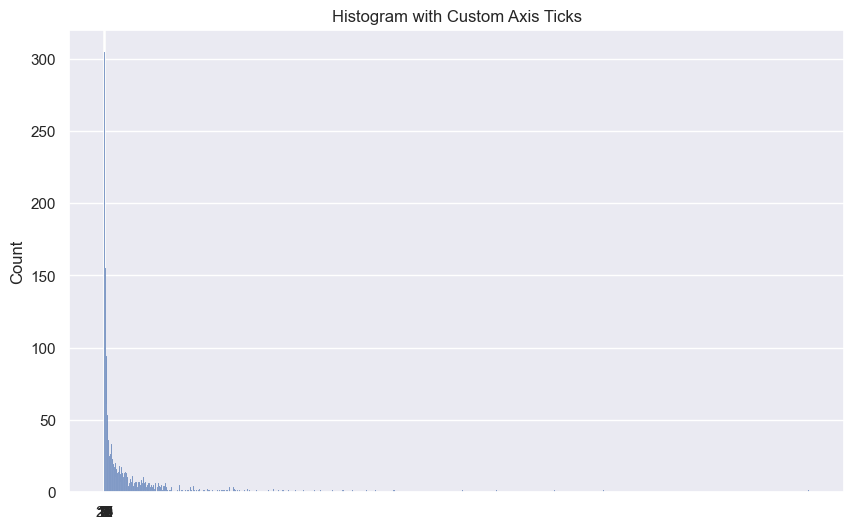

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your data
x = view_number_list_in_number

# Set up the figure and axes
plt.figure(figsize=(10, 6))
ax = sns.histplot(x, bins=1000)  # Adjust bins according to your data
ax.set_xticks([j for j in range(1, 21)])

plt.title('Histogram with Custom Axis Ticks')

plt.show()

In [ ]:
if item == '統計中':
            new_view_number_list.append(0)
            new_view_number_list.remove(item)
        elif int(item) < 1000:
            new_view_number_list.append(0)
            new_view_number_list.remove(item)
        elif 2000 > int(item) >= 1000:
            new_view_number_list.append(0.1)
            new_view_number_list.remove(item)
        elif 3000 > int(item) >= 2000:
            new_view_number_list.append(0.2)
            new_view_number_list.remove(item)
        elif 4000 > int(item) >= 3000:
            new_view_number_list.append(0.3)
            new_view_number_list.remove(item)
        elif 5000 > int(item) >= 4000:
            new_view_number_list.append(0.4)
            new_view_number_list.remove(item)
        elif 6000 > int(item) >= 5000:
            new_view_number_list.append(0.5)
            new_view_number_list.remove(item)
        elif 7000 > int(item) >= 6000:
            new_view_number_list.append(0.6)
            new_view_number_list.remove(item)
        elif 8000 > int(item) >= 7000:
            new_view_number_list.append(0.7)
            new_view_number_list.remove(item)
        elif 9000 > int(item) >= 8000:
            new_view_number_list.append(0.8)
            new_view_number_list.remove(item)
        elif 10000 > int(item) >= 9000:
            new_view_number_list.append(0.9)
            new_view_number_list.remove(item)